In [1]:
# Importando bibliotecas que iremos utilizar...

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from datetime import datetime, timedelta
import datetime as dt
import matplotlib.dates as mdates

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tab_calendario = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dim_calendario.csv')
tab_produto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dim_produto.csv')
tab_setor = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dim_setor.csv')
tab_fato_energia = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fato_energia.csv')
tab_fato_populacao = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fato_populacao.csv')
tab_pais = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dim_pais.csv')

In [4]:
tab_pais = tab_pais.rename (columns = {'fk_pais_1':'fk_pais'})


In [5]:
tab_energia = pd.merge(tab_fato_energia,tab_setor, on = 'fk_setor', how = 'inner')
tab_energia = pd.merge(tab_energia, tab_produto, on = 'fk_produto', how = 'inner')
tab_energia = pd.merge(tab_energia, tab_pais, on = 'fk_pais', how = 'inner')
tab_energia = pd.merge(tab_energia, tab_calendario, on = 'fk_calendario', how = 'inner')



In [6]:
tab_energia

,id_energia,fk_pais,fk_setor,fk_produto,fk_calendario,valor,nome_setor,nome_produto,tipo,nome_pais,pais_bloco,pais_regiao,pais_renda,ano
0,1,2,9,1,1,1368.251838,Production (PJ),"Coal, peat and oil shale",NRW,Australia,AUS,East Asia & Pacific,High income,1971
1,2,2,5,1,1,0,Imports (PJ),"Coal, peat and oil shale",NRW,Australia,AUS,East Asia & Pacific,High income,1971
2,3,2,4,1,1,-541.4240011,Exports (PJ),"Coal, peat and oil shale",NRW,Australia,AUS,East Asia & Pacific,High income,1971
3,4,2,11,1,1,884.2974695,Total energy supply (PJ),"Coal, peat and oil shale",NRW,Australia,AUS,East Asia & Pacific,High income,1971
4,5,2,3,1,1,-516.5385537,"Electricity, CHP and heat plants (PJ)","Coal, peat and oil shale",NRW,Australia,AUS,East Asia & Pacific,High income,1971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217795,217666,1,10,5,50,0,Residential (PJ),Heat,NRW,Africa,CAF,Sub-Saharan Africa,Low income,2020
217796,217667,1,1,5,50,0,Commercial and public services (PJ),Heat,NRW,Africa,CAF,Sub-Saharan Africa,Low income,2020
217797,217668,1,8,5,50,0,Other final consumption (PJ),Heat,NRW,Africa,CAF,Sub-Saharan Africa,Low income,2020
217798,217798,1,2,4,50,640427.364,Electricity output (GWh),Fossil fuels,NRW,Africa,CAF,Sub-Saharan Africa,Low income,2020


In [7]:
final = tab_energia[['nome_pais','pais_regiao','pais_bloco','pais_renda','tipo','nome_setor','nome_produto','ano','valor']]
final


,nome_pais,pais_regiao,pais_bloco,pais_renda,tipo,nome_setor,nome_produto,ano,valor
0,Australia,East Asia & Pacific,AUS,High income,NRW,Production (PJ),"Coal, peat and oil shale",1971,1368.251838
1,Australia,East Asia & Pacific,AUS,High income,NRW,Imports (PJ),"Coal, peat and oil shale",1971,0
2,Australia,East Asia & Pacific,AUS,High income,NRW,Exports (PJ),"Coal, peat and oil shale",1971,-541.4240011
3,Australia,East Asia & Pacific,AUS,High income,NRW,Total energy supply (PJ),"Coal, peat and oil shale",1971,884.2974695
4,Australia,East Asia & Pacific,AUS,High income,NRW,"Electricity, CHP and heat plants (PJ)","Coal, peat and oil shale",1971,-516.5385537
...,...,...,...,...,...,...,...,...,...
217795,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Residential (PJ),Heat,2020,0
217796,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Commercial and public services (PJ),Heat,2020,0
217797,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Other final consumption (PJ),Heat,2020,0
217798,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Electricity output (GWh),Fossil fuels,2020,640427.364


In [8]:
Total= final[(final['nome_setor'] == 'Total energy supply (PJ)')]
Total

,nome_pais,pais_regiao,pais_bloco,pais_renda,tipo,nome_setor,nome_produto,ano,valor
3,Australia,East Asia & Pacific,AUS,High income,NRW,Total energy supply (PJ),"Coal, peat and oil shale",1971,884.2974695
15,Australia,East Asia & Pacific,AUS,High income,NRW,Total energy supply (PJ),"Crude, NGL and feedstocks",1971,1051.352762
27,Australia,East Asia & Pacific,AUS,High income,NRW,Total energy supply (PJ),Oil products,1971,-40.37049887
39,Australia,East Asia & Pacific,AUS,High income,NRW,Total energy supply (PJ),Natural gas,1971,75.06450081
51,Australia,East Asia & Pacific,AUS,High income,NRW,Total energy supply (PJ),Nuclear,1971,0
...,...,...,...,...,...,...,...,...,...
217740,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Total energy supply (PJ),Natural gas,2020,5576.588536
217752,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Total energy supply (PJ),Nuclear,2020,108.0327289
217765,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Total energy supply (PJ),Renewables and waste,2020,17320.38447
217777,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Total energy supply (PJ),Electricity,2020,0.6764110344


In [9]:
Total1= final[(final['nome_setor'] == 'Production (PJ)')]
Total1

,nome_pais,pais_regiao,pais_bloco,pais_renda,tipo,nome_setor,nome_produto,ano,valor
0,Australia,East Asia & Pacific,AUS,High income,NRW,Production (PJ),"Coal, peat and oil shale",1971,1368.251838
12,Australia,East Asia & Pacific,AUS,High income,NRW,Production (PJ),"Crude, NGL and feedstocks",1971,620.7177142
24,Australia,East Asia & Pacific,AUS,High income,NRW,Production (PJ),Oil products,1971,0
36,Australia,East Asia & Pacific,AUS,High income,NRW,Production (PJ),Natural gas,1971,75.06450081
48,Australia,East Asia & Pacific,AUS,High income,NRW,Production (PJ),Nuclear,1971,0
...,...,...,...,...,...,...,...,...,...
217737,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Production (PJ),Natural gas,2020,8279.611624
217749,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Production (PJ),Nuclear,2020,108.0327289
217762,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Production (PJ),Renewables and waste,2020,17187.83604
217774,Africa,Sub-Saharan Africa,CAF,Low income,NRW,Production (PJ),Electricity,2020,0


In [10]:
fossil= final[(final['nome_produto'] == 'Fossil fuels')]
fossil

,nome_pais,pais_regiao,pais_bloco,pais_renda,tipo,nome_setor,nome_produto,ano,valor
97,Australia,East Asia & Pacific,AUS,High income,NRW,Electricity output (GWh),Fossil fuels,1971,41201
196,Austria,Europe & Central Asia,AUT,High income,NRW,Electricity output (GWh),Fossil fuels,1971,11752
295,Belgium,Europe & Central Asia,BEL,High income,NRW,Electricity output (GWh),Fossil fuels,1971,33103
394,Canada,North America,CAN,High income,NRW,Electricity output (GWh),Fossil fuels,1971,55105
493,Chile,Latin America & Caribbean,CHL,High income,NRW,Electricity output (GWh),Fossil fuels,1971,3649
...,...,...,...,...,...,...,...,...,...
217402,Morocco,Middle East & North Africa,MAR,Lower middle income,NRW,Electricity output (GWh),Fossil fuels,2020,31352.72
217501,Singapore,East Asia & Pacific,SGP,High income,NRW,Electricity output (GWh),Fossil fuels,2020,51593.76
217600,South Africa,Sub-Saharan Africa,ZAF,Upper middle income,NRW,Electricity output (GWh),Fossil fuels,2020,212059.965
217699,Thailand,East Asia & Pacific,THA,Upper middle income,NRW,Electricity output (GWh),Fossil fuels,2020,149836.984


 # Análise Exploratória

In [11]:
# Shape dos dados
final.shape

(217800, 9)

In [12]:
# Tipos de Dados
final.dtypes

nome_pais       object
pais_regiao     object
pais_bloco      object
pais_renda      object
tipo            object
nome_setor      object
nome_produto    object
ano              int64
valor           object
dtype: object

In [ ]:
final.valor= pd.to_numeric(final.valor , errors='coerce')

In [14]:
final.dtypes

nome_pais        object
pais_regiao      object
pais_bloco       object
pais_renda       object
tipo             object
nome_setor       object
nome_produto     object
ano               int64
valor           float64
dtype: object

In [15]:
# Verificando valores missing
print(final.isna().sum())

nome_pais           0
pais_regiao         0
pais_bloco          0
pais_renda          0
tipo                0
nome_setor          0
nome_produto        0
ano                 0
valor           21381
dtype: int64


In [ ]:
# Removendo as linhas com valores missing
final.dropna(inplace = True)

In [17]:
final.dtypes

nome_pais        object
pais_regiao      object
pais_bloco       object
pais_renda       object
tipo             object
nome_setor       object
nome_produto     object
ano               int64
valor           float64
dtype: object

In [18]:
# Shape
final.shape

(196419, 9)

In [19]:
# Verificando Valores Únicos
final.nunique()

nome_pais           44
pais_regiao          7
pais_bloco          44
pais_renda           4
tipo                 2
nome_setor          13
nome_produto        10
ano                 50
valor           101741
dtype: int64

In [ ]:
#final = final[(final['valor']>0)]
#final1 = final[(final['ano']> 2015)]

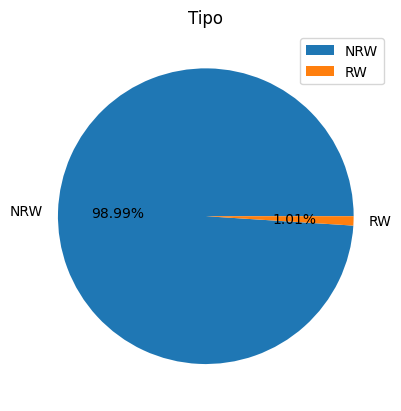

In [20]:
import matplotlib.pyplot as plt

# Gráfico de Pizza de Tipos de Visitantes
labels = ['NRW', 'RW']
plt.title("Tipo")
plt.pie(final['tipo'].value_counts(), labels = labels, autopct = '%.2f%%')
plt.legend()
plt.show()

In [21]:
final['pais_renda'].value_counts()

High income            163155
Upper middle income     19107
Lower middle income      9207
Low income               4950
Name: pais_renda, dtype: int64

In [22]:
final['nome_produto'].value_counts()

Nuclear                      25883
Crude, NGL and feedstocks    23892
Oil products                 23892
Natural gas                  23889
Coal, peat and oil shale     23887
Electricity                  23853
Renewables and waste         23851
Heat                         23290
Fossil fuels                  1991
Renewable sources             1991
Name: nome_produto, dtype: int64

In [23]:
final['nome_setor'].value_counts()

Total energy supply (PJ)                 15928
Oil refineries, transformation (PJ)      15928
Total final consumption (PJ)             15928
Industry (PJ)                            15928
Transport (PJ)                           15928
Imports (PJ)                             15901
Exports (PJ)                             15897
Electricity, CHP and heat plants (PJ)    15842
Other final consumption (PJ)             15804
Commercial and public services (PJ)      15799
Residential (PJ)                         15794
Production (PJ)                          15769
Electricity output (GWh)                  5973
Name: nome_setor, dtype: int64

In [24]:
final['tipo'].value_counts()

NRW    194428
RW       1991
Name: tipo, dtype: int64

In [25]:
final['pais_regiao'].value_counts()

Europe & Central Asia         120782
East Asia & Pacific            28809
Latin America & Caribbean      17919
North America                   9809
Sub-Saharan Africa              8019
Middle East & North Africa      8012
South Asia                      3069
Name: pais_regiao, dtype: int64

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [27]:
ano = final['ano'].values.reshape(-1, 1)
producao_energia_limpa = final['valor'].values

In [28]:
x= final['ano'].values.reshape(-1, 1)
y = final['valor'].values.reshape(-1, 1)


In [29]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(x, y, test_size= 0.1, train_size=0.8, random_state=42)

In [30]:
modelo = LinearRegression()

In [31]:

modelo.fit(X_treinamento, y_treinamento)


LinearRegression()

In [32]:
anos_futuros = np.arange(2023, 2031).reshape(-1,1)
previsao_energia_limpa = modelo.predict(anos_futuros)

In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
y_pred = modelo.predict(previsao_energia_limpa)

In [35]:
producao_energia_limpa

array([ 1.36825184e+03,  0.00000000e+00, -5.41424001e+02, ...,
        0.00000000e+00,  6.40427364e+05,  1.84009911e+05])

In [36]:
total_dados_historicos = final.groupby(['ano']).sum('valor')
total_dados_historicos



,valor
ano,
1971,4.438769e+06
1972,4.792681e+06
1973,5.140974e+06
1974,5.191831e+06
1975,5.277953e+06
1976,5.629186e+06
1977,5.860593e+06
1978,6.118502e+06
1979,6.342477e+06


In [ ]:
total_dados_historicos

,valor
ano,
1971,4.438769e+06
1972,4.792681e+06
1973,5.140974e+06
1974,5.191831e+06
1975,5.277953e+06
1976,5.629186e+06
1977,5.860593e+06
1978,6.118502e+06
1979,6.342477e+06


In [ ]:
previsao_energia_limpa.dtype

dtype('float64')

In [37]:
previsao_energia_limpa

array([[3814.06436708],
       [3857.2700161 ],
       [3900.47566511],
       [3943.68131413],
       [3986.88696314],
       [4030.09261216],
       [4073.29826118],
       [4116.50391019]])

In [38]:
anos_futuros

array([[2023],
       [2024],
       [2025],
       [2026],
       [2027],
       [2028],
       [2029],
       [2030]])

In [39]:
tabela_previsao = np.append(anos_futuros.reshape(-1, 1), previsao_energia_limpa.reshape(-1, 1), axis=1)
tabela_previsao


array([[2023.        , 3814.06436708],
       [2024.        , 3857.2700161 ],
       [2025.        , 3900.47566511],
       [2026.        , 3943.68131413],
       [2027.        , 3986.88696314],
       [2028.        , 4030.09261216],
       [2029.        , 4073.29826118],
       [2030.        , 4116.50391019]])

In [40]:
previsao1 = {'ano': [2023, 2024,2025,2026,2027,2028,2029,2030], 'valor': [4421.67441701, 3961.45815082,3501.24188462,3041.02561843,2580.80935224,7587.37351611,7651.09165338,7714.80979066]}
previsao1= pd.DataFrame(data=previsao1)
previsao1

,ano,valor
0,2023,4421.674417
1,2024,3961.458151
2,2025,3501.241885
3,2026,3041.025618
4,2027,2580.809352
5,2028,7587.373516
6,2029,7651.091653
7,2030,7714.809791


In [41]:
previsao = {'ano': [2023, 2024,2025,2026,2027,2028,2029,2030], 'valor': [7268.78282973, 7332.50096701,7396.21910428,7459.93724156,7523.65537883,7587.37351611,7651.09165338,7714.80979066]}
previsao = pd.DataFrame(data=previsao)
previsao


,ano,valor
0,2023,7268.782830
1,2024,7332.500967
2,2025,7396.219104
3,2026,7459.937242
4,2027,7523.655379
5,2028,7587.373516
6,2029,7651.091653
7,2030,7714.809791


In [42]:
previsao_pred = previsao['valor']

In [43]:
pd.concat([total_dados_historicos, previsao])

,valor,ano
1971,4.438769e+06,NaN
1972,4.792681e+06,NaN
1973,5.140974e+06,NaN
1974,5.191831e+06,NaN
1975,5.277953e+06,NaN
1976,5.629186e+06,NaN
1977,5.860593e+06,NaN
1978,6.118502e+06,NaN
1979,6.342477e+06,NaN
1980,6.448615e+06,NaN


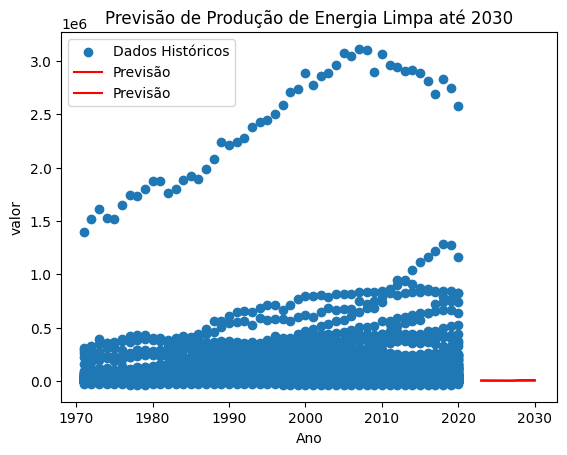

In [44]:
plt.scatter(ano, producao_energia_limpa, label='Dados Históricos')
plt.plot(anos_futuros, previsao_energia_limpa, label='Previsão', color='red')
plt.xlabel('Ano')
plt.ylabel('valor')
plt.title('Previsão de Produção de Energia Limpa até 2030')
plt.legend()
plt.show()

In [ ]:
final.corr()

<ipython-input-51-4fee8eca12fa>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  final.corr()


,ano,valor
ano,1.000000,0.014468
valor,0.014468,1.000000
